In [ ]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = []
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None

    def fit(self, X, y):
        num_class = len(np.unique(y))


        for i in range(num_class) :
            self.mean_vectors.append(np.mean(X[y==i], axis=0))
  
        self.sw = np.zeros((X.shape[1], X.shape[1]))
        for i in range(num_class):
            Xi = X[y==i]
            Si = np.zeros((X.shape[1], X.shape[1]))
            for row in Xi:
                row, mv = row.reshape(X.shape[1], 1), self.mean_vectors[i].reshape(X.shape[1], 1)
                Si += (row-mv).dot((row-mv).T)
            self.sw += Si

        overall_mean = np.mean(X, axis=0)
        overall_mean = overall_mean.reshape(X.shape[1], 1)
        self.sb = np.zeros((X.shape[1], X.shape[1]))
        
        for i in range(num_class):
            Ni = len(X[y==i])
            mv = self.mean_vectors[i].reshape(X.shape[1], 1)
            self.sb += Ni * np.dot((mv - overall_mean),((mv - overall_mean).T))

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(self.sw).dot(self.sb))
        # Sort eigenvectors by decreasing eigenvalues
        eig_pairs = [(eigenvalues[i], eigenvectors[:,i]) for i in range(len(eigenvalues))]
        eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
        self.w = eig_pairs[0][1].reshape(X.shape[1],1)

        # Compute the slope of the projection line
        self.slope = self.w[1]/self.w[0]

    def predict_using_class_mean(self, X, y, X_test):
        # return y_pred
        X_proj = X @ self.w
        X_test_proj = X_test @ self.w
        y_pred = []
        for x in X_test_proj:
            distances = [np.linalg.norm(x - np.dot(self.mean_vectors[i], self.w)) for i in range(len(self.mean_vectors))]
            y_pred.append(np.argmin(distances))
        return np.array(y_pred)
    

    def predict_using_knn(self, X, y, X_test, k=1):
        X_proj = X @ self.w
        X_test_proj = X_test @ self.w

        y_pred = []
        for x in X_test_proj:
            distances = [np.linalg.norm(x - X_proj[i] ) for i in range(len(X_proj))]
            labels = y[np.argsort(distances)[:k]]
            counts = np.bincount(labels)
            y_pred.append(np.argmax(counts))

        return np.array(y_pred)


    def show_confusion_matrix(self, y, y_pred):
        confusion_matrix = np.zeros(   (  len(np.unique(y)), len(np.unique(y)) ) )
        for i in range(y.shape[0]) :
            confusion_matrix[y[i]][y_pred[i]] += 1

        plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(np.unique(y)))
        plt.xticks(tick_marks, np.arange(len(np.unique(y))))
        plt.yticks(tick_marks, np.arange(len(np.unique(y))))


        
        thresh = confusion_matrix.max() / 2.
        for i, j in np.ndindex(confusion_matrix.shape):
            plt.text(j, i, int(confusion_matrix[i, j]),
                    horizontalalignment="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")
        
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()   
        pass

    def plot_projection(self, X, y):
        # fig, ax = plt.subplots(figsize=(31,31))
        # plt.xlim(-15, 15)
        # plt.ylim(-15, 15)

        # draw projection line with intercept = 2
        x1 = np.linspace(-15, 5, 50)
        y1 = x1 * self.slope

        plt.plot(x1, y1)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Projection Line: w={self.slope},b=0')

        # plot class1 training data 
        x_c1, y_c1 = X[y == 0][:, 0], X[y == 0][:, 1]
        plt.scatter(x_c1, y_c1, color='red', s=1, label='class1')

        # plot class1 training data 
        x_c2, y_c2 = X[y == 1][:, 0], X[y == 1][:, 1]
        plt.scatter(x_c2, y_c2, color='blue', s=1, label='class2')

        x_c3, y_c3 = X[y == 2][:, 0], X[y == 2][:, 1]
        plt.scatter(x_c3, y_c3, color='green', s=1, label='class3')

        # project training data
        w = np.squeeze(self.w)
        for i in range(len(X)):
            projection = (np.dot(X[i], w) / np.dot(w, w)) * w
            if y[i] == 0:
                plt.scatter(projection[0], projection[1], s=10, color='red')
                plt.plot([X[i][0], projection[0]], [X[i][1], projection[1]], c='red', alpha=0.05)
            elif y[i] == 1:
                plt.scatter(projection[0], projection[1], s=10, color='blue')
                plt.plot([X[i][0], projection[0]], [X[i][1], projection[1]], c='blue', alpha=0.05)
            else  : 
                plt.scatter(projection[0], projection[1], s=10, color='green')
                plt.plot([X[i][0], projection[0]], [X[i][1], projection[1]], c='green', alpha=0.05)

    def accuracy_score(self, y, y_pred):
        return np.mean(y == y_pred)

In [ ]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None

    def one_hot(self, y ) :
        y_hot = np.zeros( ( len(y), len(np.unique(y)) ))
        for i in range(len(y)) :
            y_hot[i][y[i]] = 1
        return y_hot
    

    def fit(self, X, y, batch_size=16, lr=0.001, epochs=100 , loss_count = 1):
        self.weights = np.ones((X.shape[1] + 1, len(np.unique(y))))
        self.bais = np.ones( len(np.unique(y))   )
        y = y.reshape( (  y.shape[0] , 1) )
        X_epoch=np.concatenate((X, np.ones((len(X),1))), axis=1)    

        y_hot = self.one_hot( y )
        for epoch in range(epochs):
            for batch in range(0,len(X),batch_size):
                batch_end = min(batch+batch_size , len(X))
                X_batch = X_epoch[ batch : batch_end ]
                y_batch = y_hot[ batch : batch_end ]
                y_pred = X_batch @ self.weights
                y_pred = self.softmax(y_pred)
                w_grad = (1/batch_size)*np.dot(X_batch.T, (y_pred - y_batch))
                self.weights -=  lr * w_grad
            if epoch % loss_count == 0 :
                y_pred = self.softmax(np.dot(X_epoch, self.weights))           
                loss = self.cross_entropy(y, y_pred)
                self.train_loss.append(loss)
                self.epoch.append(epoch)

        print(self.weights)    



    def predict(self, X):
        X_predict=np.concatenate((X, np.ones((len(X),1))), axis=1)
        probs = self.softmax(np.dot(X_predict, self.weights))
        pred = np.argmax(probs, axis=1)
        return pred

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        accuracy = self.accuracy_score(y, y_pred)
        return accuracy


    def softmax(self, z):
        exp_z = np.exp(z)
        for i in range(len(z)):
            exp_z[i] /= np.sum(exp_z[i])
        return exp_z
        

    def cross_entropy(self, y, y_hat):
        m = y.shape[0]
        log_y = [-np.log(y_hat[i][y[i]]) for i in range(len(y))]
        loss = np.sum(log_y) / m
        return loss
    
    def accuracy_score(self, y, y_pred):
        num = 0
        for i in range(len(y)) :
            if(y[i]==y_pred[i]) :
              num += 1
        print(f'ans : {str(num/len(y))}' )
        return np.mean(y == y_pred)
    



    def show_confusion_matrix(self, X, y):
        confusion_matrix = np.zeros(   (  len(np.unique(y)), len(np.unique(y)) ) )
        y_pred = self.predict(X)
        for i in range(y.shape[0]) :
            confusion_matrix[y[i]][y_pred[i]] += 1

        plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(len(np.unique(y)))
        plt.xticks(tick_marks, np.arange(len(np.unique(y))))
        plt.yticks(tick_marks, np.arange(len(np.unique(y))))


        
        thresh = confusion_matrix.max() / 2.
        for i, j in np.ndindex(confusion_matrix.shape):
            plt.text(j, i, int(confusion_matrix[i, j]),
                    horizontalalignment="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")
        
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()    



    def plot_curve(self):
        # self.epoch and self.train_loss may be helpful here. 
        plt.plot(self.epoch, self.train_loss, label="Training Loss")
        plt.title("Training Curve")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()    

# Prepare data for Q1 ~ Q12

In [ ]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [ ]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


In [ ]:
df_train.head()
df_test.head()

,Feature1,Feature2,Target
0,-1.607103,7.146919,2
1,-2.097351,9.010508,2
2,-11.461453,-5.356925,1
3,-2.165248,6.744082,2
4,-1.352848,7.185533,2


# MultiClass Logistic Regression

In [ ]:
# For Q1
lr = 0.1
batch_size = 16
epoch = 1000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epochs=epoch)

[[ 0.60340734 -0.01977367  2.41636633]
 [ 1.2290092  -0.97770969  2.74870049]
 [ 3.01373641  0.9910362  -1.00477261]]


In [ ]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

ans : 0.896
Training acc:  0.896


In [ ]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

ans : 0.887
Testing acc:  0.887


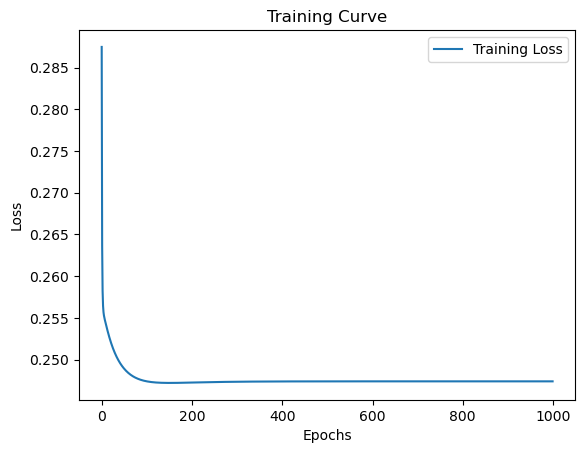

In [ ]:
# For Q4
logistic_reg.plot_curve()

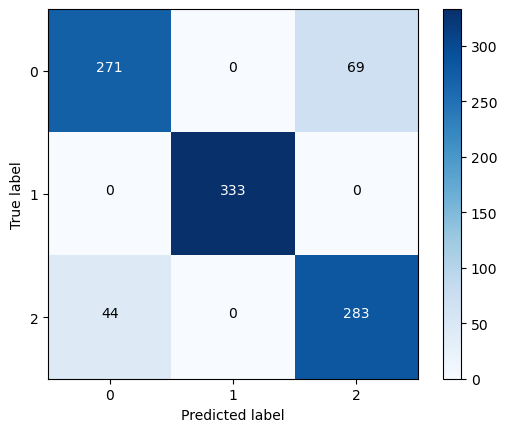

In [ ]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

# Fisher's Linear Discriminant Analysis

In [ ]:
fld = FLD()

fld.fit(X_train, y_train)

In [ ]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [array([-4.17505764,  6.35526804]), array([-9.43385176, -4.87830741]), array([-2.54454008,  7.53144179])]


In [ ]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [ ]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [ ]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384]
 [-0.8974315 ]]


FLD using class mean, accuracy:  0.861


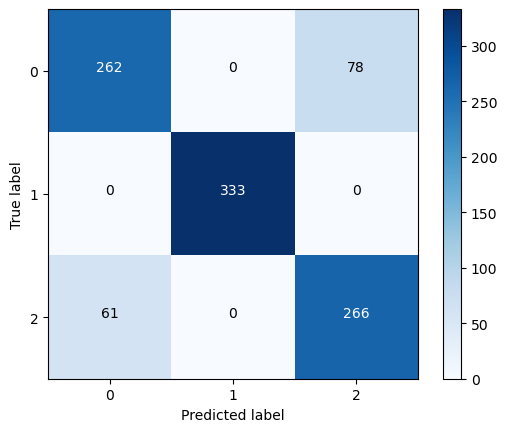

In [ ]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [ ]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.822
FLD using knn (k=2), accuracy:  0.819
FLD using knn (k=3), accuracy:  0.843
FLD using knn (k=4), accuracy:  0.84
FLD using knn (k=5), accuracy:  0.862


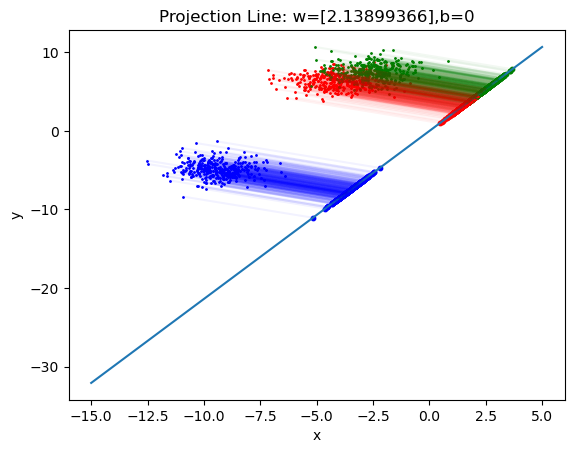

In [ ]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [ ]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [ ]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [ ]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [ ]:
df_train.corr()

,Feature1,Feature2,Feature3,Feature4,Target
Feature1,1.000000,0.532584,0.224169,0.214851,-0.657016
Feature2,0.532584,1.000000,0.938422,0.431155,-0.477465
Feature3,0.224169,0.938422,1.000000,0.421574,-0.265032
Feature4,0.214851,0.431155,0.421574,1.000000,-0.215316
Target,-0.657016,-0.477465,-0.265032,-0.215316,1.000000


In [ ]:
def varible_extend( df, expend = ['Feature1','Feature2','Feature3','Feature4'] ) :
    X = df.drop('Target', axis=1)

    for i in range(len(expend)) :
        for j in range(i,len(expend)) :
            name = f'{expend[i]}*{expend[j]}'
            X[name] = X[expend[i]]*X[expend[j]]

    return X

In [ ]:
# Data processing
X_train = varible_extend(df_train).to_numpy()
y_train = df_train[['Target']].to_numpy().ravel().astype(int)

X_val = varible_extend(df_val).to_numpy()
y_val = df_val[['Target']].to_numpy().ravel().astype(int)

X_test = varible_extend(df_test).to_numpy()
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val",  X_val.shape)
print("y_val",  y_val.shape)
# Refer to section "Prepare data for Q1 ~ Q12"

X_train (1703, 14)
y_train (1703,)
X_val (730, 14)
y_val (730,)


In [ ]:
lr = 0.9
batch_size = 8
epoch = 10000000

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epochs=epoch, loss_count= 1000000)
# your_model = ...


[[ 1.96625076e+03 -1.06934070e+03 -8.93910060e+02]
 [ 3.97061910e+02 -3.00331924e+02 -9.37299863e+01]
 [ 9.04116362e+02  2.64894164e+02 -1.16601053e+03]
 [-1.48100138e+02  1.94311951e+01  1.31668943e+02]
 [ 2.82630193e+01 -5.96754091e+00 -1.92954784e+01]
 [ 6.55414680e+00 -1.61204715e+00 -1.94209966e+00]
 [ 1.15005826e+03 -7.41381860e+02 -4.05676398e+02]
 [ 1.95837818e+03 -1.04495364e+03 -9.10424536e+02]
 [ 1.83456114e+00  2.31455606e-01  9.33983250e-01]
 [ 2.02899740e+02 -1.97593023e+02 -2.30671724e+00]
 [ 3.84932056e+02 -2.98237044e+02 -8.36950122e+01]
 [-1.46742838e+02  2.49688503e+02 -9.99456645e+01]
 [-6.78772422e+02 -6.24365695e+02  1.30613812e+03]
 [ 4.43513478e+02  4.69933544e+01 -4.87506833e+02]
 [-4.05835474e+02  7.92507603e+01  3.29584714e+02]]


In [ ]:
y_pred = logistic_reg.predict( X_val)
print("accuracy: ", logistic_reg.accuracy_score(y_val, y_pred))

ans : 0.915068493150685
accuracy:  0.915068493150685


In [ ]:
y_pred = logistic_reg.predict( X_train)
print("accuracy: ", logistic_reg.accuracy_score(y_train, y_pred))

ans : 0.916030534351145
accuracy:  0.916030534351145


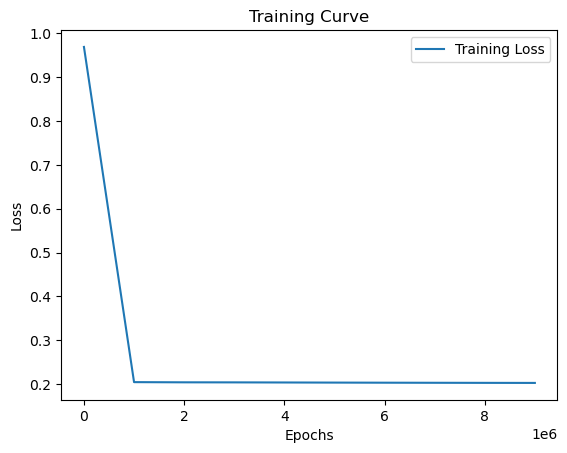

In [ ]:
logistic_reg.plot_curve()

In [ ]:
test_pred = logistic_reg.predict(X_test)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


# Output the csv file

In [ ]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("311553032_1_output.csv")